In [ ]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Embedding, Reshape
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import plotly.express as px

plt.rcParams['font.size'] =  12

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brillyskripsi","key":"2fe52460b9aa64f09bb59e1efae7840c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d niten19/face-shape-dataset

 98% 628M/639M [00:04<00:00, 139MB/s]
100% 639M/639M [00:04<00:00, 152MB/s]


In [ ]:
!mkdir datasets
!unzip -qq face-shape-dataset.zip -d dataset
!ls dataset

'FaceShape Dataset'


In [ ]:
train_dir = '/content/dataset/FaceShape Dataset/training_set'
test_dir = '/content/dataset/FaceShape Dataset/testing_set'

In [ ]:
training_data = []
test_data = []
labels = os.listdir(train_dir)
for folder in os.listdir(train_dir):
    training_data.append(len(os.listdir(os.path.join(train_dir,folder))))
    
for folder in os.listdir(test_dir):
    test_data.append(len(os.listdir(os.path.join(test_dir,folder))))

In [ ]:
fig = px.bar(x=labels, y=training_data, title='Class Count Training Data')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [ ]:
batch_size = 32
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             horizontal_flip=True,
                            shear_range = 0.3,
                            fill_mode = 'nearest',
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #zoom_range = 0.1,
                            validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_directory(train_dir,  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                classes=['Heart', 'Oblong', 'Oval', 'Round', 'Square'],
                                                shuffle=True,
                                                subset='training',
                                                class_mode='categorical')  

validation_generator = datagen.flow_from_directory(train_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    classes=['Heart', 'Oblong', 'Oval', 'Round', 'Square'],
                                                    shuffle=True,
                                                    subset='validation',
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(img_size, img_size),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 3200 images belonging to 5 classes.
Found 800 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


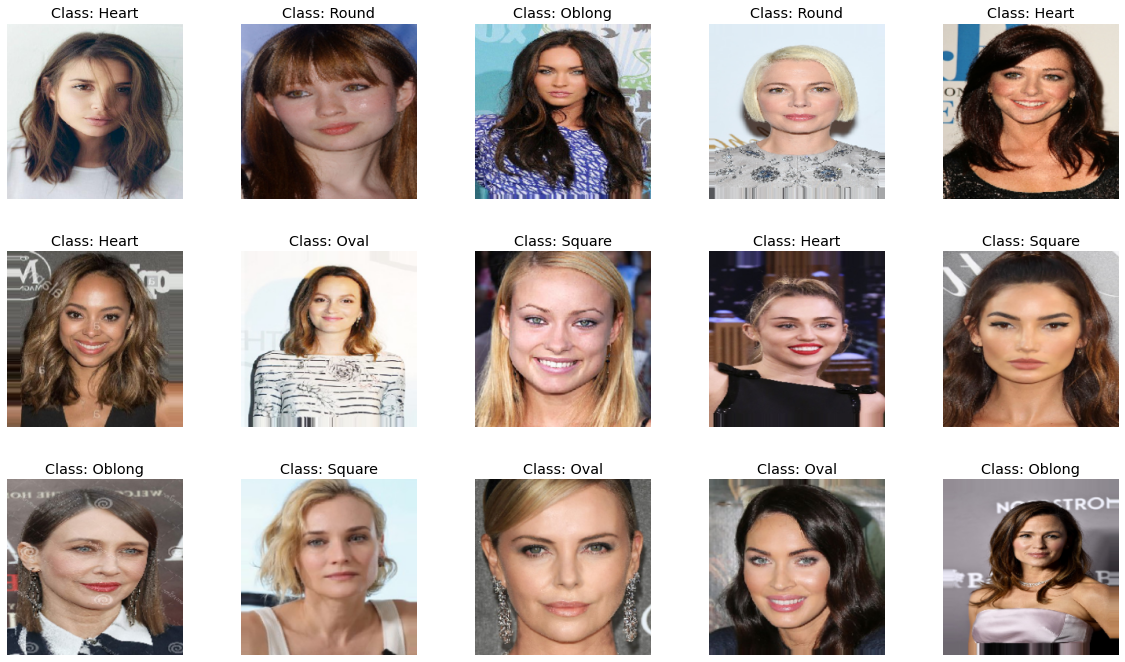

In [ ]:
labels = [k for k,v in train_generator.class_indices.items()]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [ ]:
from tensorflow.keras.applications import ResNet50V2
img_size = 224
base_model3 = ResNet50V2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

94683136/94668760 [==============================] - 0s 0us/step


In [ ]:
base_model3.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
base_model3.layers

In [ ]:
len(base_model3.layers)

190

In [ ]:
freeze_index3 = None
for i,layer in enumerate(base_model3.layers):
    if 'block4' in layer._name:
        freeze_index3 = i
        break
        
for layer in base_model3.layers[:freeze_index3]:
    layer.trainable = False

In [ ]:
last_output3 = base_model3.output
x3 = GlobalAveragePooling2D()(last_output3)
x3 = Dense(512, activation='relu')(x3)
outputs3 = Dense(5, activation='softmax')(x3)
model3 = Model(inputs=base_model3.inputs, outputs=outputs3)
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
model_name3 = "model_Renset50.h5"
checkpoint3 = ModelCheckpoint(model_name3,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping3 = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction3 = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
history3 = model3.fit(train_generator,
                    epochs=25,
                    validation_data=validation_generator,
                    callbacks=[checkpoint3,earlystopping3,learning_rate_reduction3])

Epoch 1/25
100/100 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9341
Epoch 1: val_loss improved from 0.70510 to 0.58991, saving model to model_Renset50.h5
100/100 [==============================] - 85s 847ms/step - loss: 0.1942 - accuracy: 0.9341 - val_loss: 0.5899 - val_accuracy: 0.8112 - lr: 9.0000e-06
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9488
Epoch 2: val_loss did not improve from 0.58991
100/100 [==============================] - 83s 832ms/step - loss: 0.1562 - accuracy: 0.9488 - val_loss: 0.6016 - val_accuracy: 0.8225 - lr: 9.0000e-06
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9572
Epoch 3: val_loss did not improve from 0.58991
100/100 [==============================] - 82s 824ms/step - loss: 0.1248 - accuracy: 0.9572 - val_loss: 0.6178 - val_accuracy: 0.8138 - lr: 9.0000e-06
Epoch 4/25
100/100 [==============================] - ETA: 0s - loss: 0.1210 - 

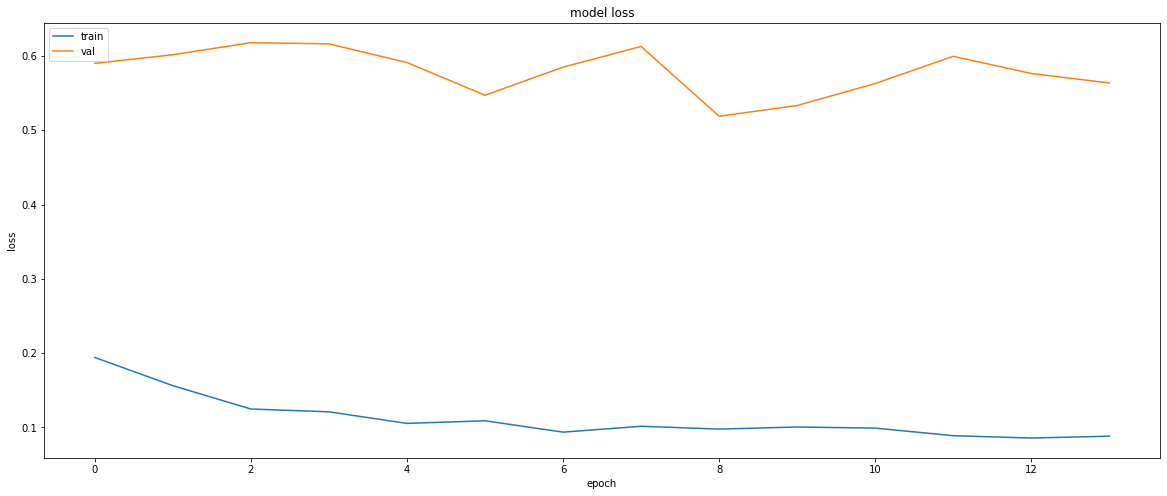

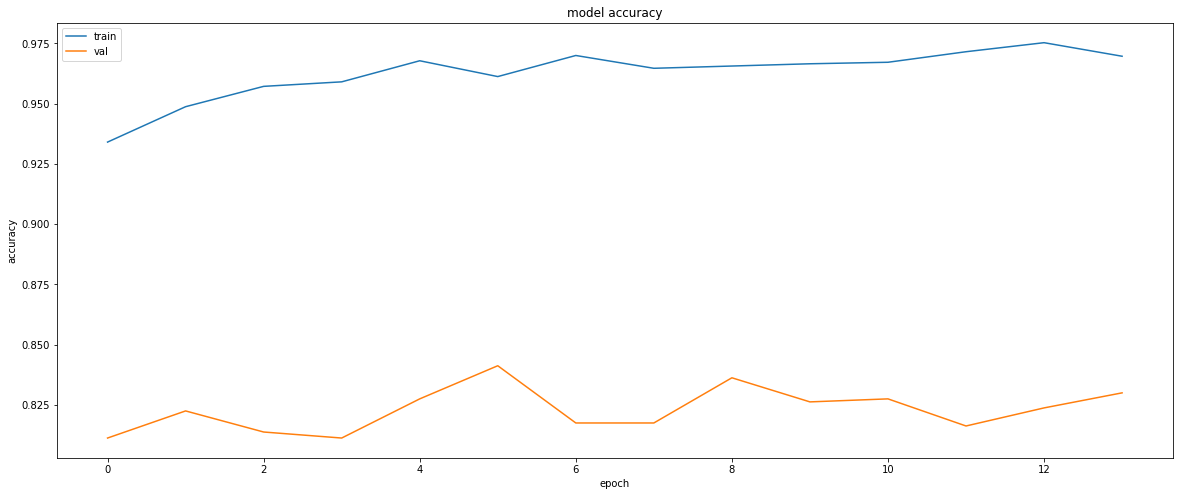

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure(figsize=(20,8))
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_loss = model3.evaluate(test_generator)

32/32 [==============================] - 12s 370ms/step - loss: 0.9108 - accuracy: 0.7620


Saving oval (1).jpg to oval (1).jpg
[0]
Heart


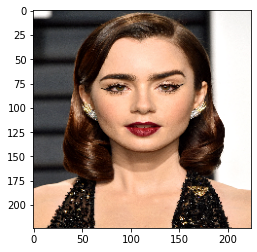

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model3.predict(images, batch_size=32)
  pr = np.argmax(classes, axis=1)
  print(pr)

  if pr==0:
    print('Heart')
  elif pr==1:
    print('Oblong')
  elif pr==2:
    print('Oval')
  elif pr==3:
    print('Round')
  else:
    print('Square')